In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import random
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt


In [ ]:
# Initialize
epochs = 180
learning_rate = 0.1
batch_size = 384
img_dims =  (50,50,3)

In [ ]:
X_train = np.load("/content/gdrive/My Drive/Dataset-Str-Kfold/x_train_fold-10.npy")
X_test = np.load("/content/gdrive/My Drive/Dataset-Str-Kfold/x_test_fold-10.npy")
y_train = np.load("/content/gdrive/My Drive/Dataset-Str-Kfold/y_train_fold-10.npy")
y_test = np.load("/content/gdrive/My Drive/Dataset-Str-Kfold/y_test_fold-10.npy")

In [ ]:
# augmenting dataset
aug = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [ ]:
model = Sequential()
inputShape = (50, 50, 3)
chanDim = -1   
        
model.add(layers.Conv2D(32, (3,3), padding='same', input_shape=inputShape, activation='relu'))
model.add(layers.BatchNormalization(axis=chanDim))
model.add(layers.MaxPool2D(pool_size=(3,3)))
model.add(layers.Dropout(0.25))
       

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization(axis=chanDim))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization(axis=chanDim))
model.add(layers.MaxPool2D(pool_size=(3,3)))
model.add(layers.Dropout(0.25))
        
        
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization(axis=chanDim))
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization(axis=chanDim))
model.add(layers.MaxPool2D(pool_size=(3,3)))
model.add(layers.Dropout(0.25))

        
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
        
model.add(layers.Dense(2, activation='softmax'))

In [ ]:
# compile the model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,staircase=True,
    decay_steps=19500,
    decay_rate=0.9)
optimizer = SGD(learning_rate=lr_schedule,momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# CHECKPOINT
checkpoint_path="/content/gdrive/My Drive/checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/180
651/650 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.8033
Epoch 00001: val_accuracy improved from -inf to 0.74826, saving model to /content/gdrive/My Drive/checkpoints/weights-improvement-01-0.75.hdf5
651/650 [==============================] - 178s 273ms/step - loss: 0.6452 - accuracy: 0.8033 - val_loss: 0.4968 - val_accuracy: 0.7483
Epoch 2/180
651/650 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.8413
Epoch 00002: val_accuracy improved from 0.74826 to 0.79435, saving model to /content/gdrive/My Drive/checkpoints/weights-improvement-02-0.79.hdf5
651/650 [==============================] - 177s 272ms/step - loss: 0.3792 - accuracy: 0.8413 - val_loss: 0.5168 - val_accuracy: 0.7943
Epoch 3/180
651/650 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.8534
Epoch 00003: val_accuracy improved from 0.79435 to 0.82311, saving model t

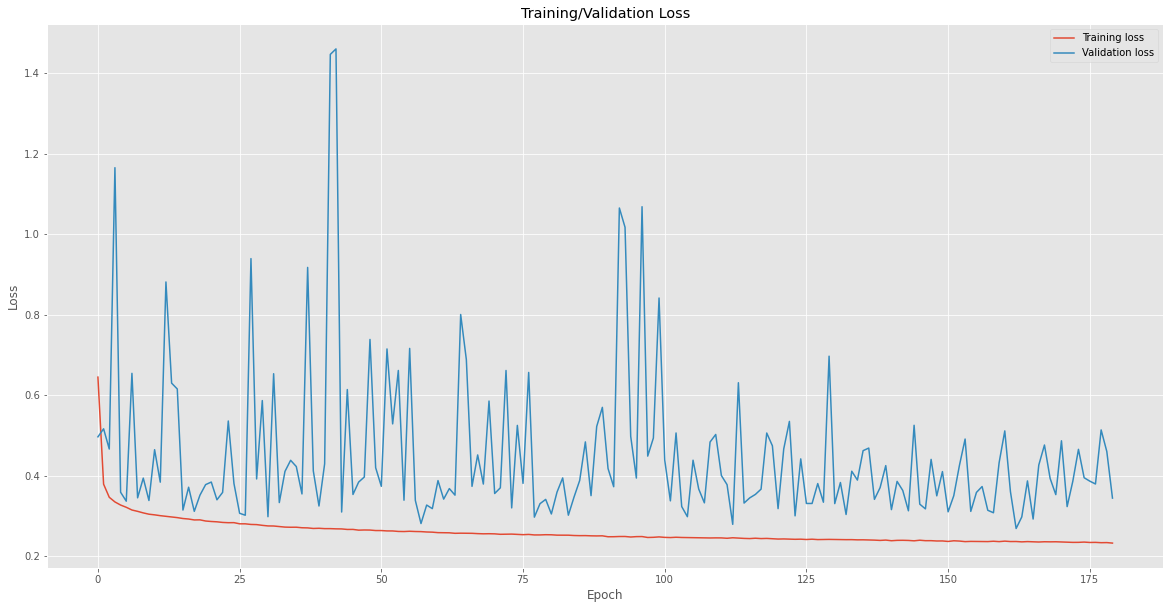

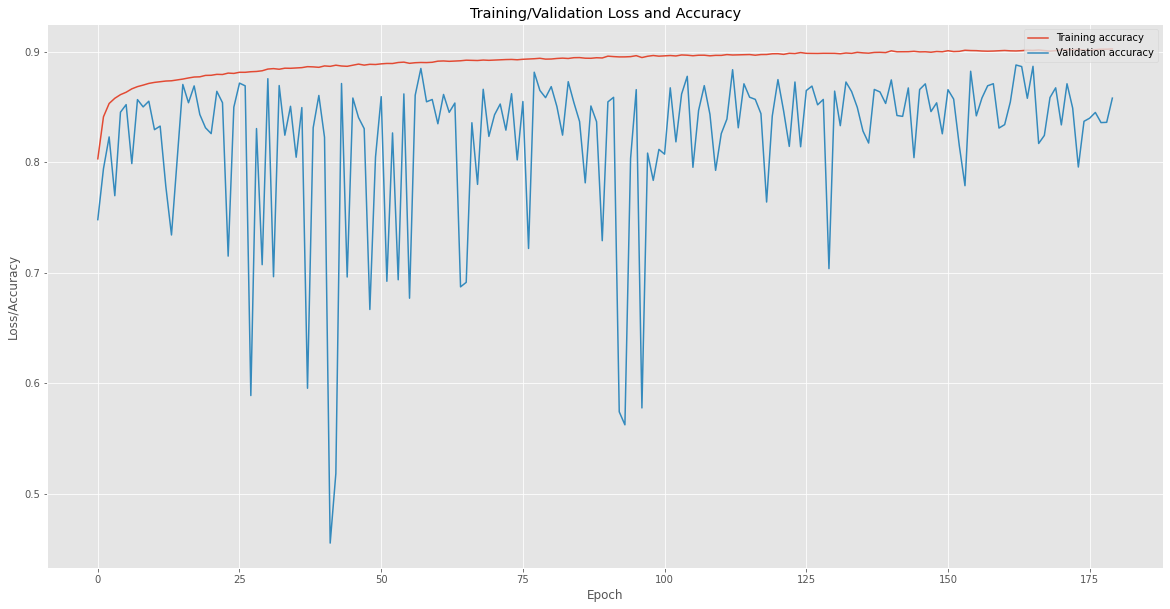

In [ ]:
# train the model
H = model.fit_generator(aug.flow(X_train, y_train,batch_size),steps_per_epoch=len(X_train)/batch_size,validation_data=(X_test, y_test),epochs=epochs, callbacks=callbacks_list, verbose=1)

# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="Training loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="Validation loss")
plt.title("Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig("/content/gdrive/My Drive/checkpoints/loss.png")
plt.show()


plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,N), H.history["accuracy"], label="Training accuracy")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="Validation accuracy")
plt.title("Training/Validation Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig("/content/gdrive/My Drive/checkpoints/accuracy.png")
plt.show()